# Task 1: Single Object Tracking
## Object Detection Algorithm and Association

### import libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
from pathlib import Path
from PIL import Image
from transformers import AutoImageProcessor, DetrForObjectDetection

/opt/anaconda3/envs/AutoMobileRobotics/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### load model

In [6]:
image_processor = AutoImageProcessor.from_pretrained("./detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("./detr-resnet-50")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of the model checkpoint at ./detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- Thi

### load images sequence

In [17]:
def load_sequence(seq_path):
    # get all jpg images form a sequence
    images = []
    image_files = sorted(Path(seq_path).glob('img/*.jpg'))
    # print(image_files)
    for img_path in image_files: # use PIL to load images
        img = Image.open(img_path)
        images.append(img)
    print(f"loaded {len(images)} images from {seq_path}")
    
    return images

### detect objects

In [107]:
def detect_objects(image, confidence_threshold=0.9):
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(
        outputs, 
        target_sizes=target_sizes, 
        threshold=confidence_threshold
        )[0]
    
    # extract detection boxes and scores
    boxes = results["boxes"]
    scores = results["scores"]
    labels = results["labels"]
    
    # find the human object with the highest confidence
    max_score_idx = torch.argmax(scores)

    x1,y1,x2,y2 = boxes[max_score_idx]
    x=int(x1)
    y=int(y1)
    w=int(x2-x1)
    h=int(y2-y1)
    
    # return (human_boxes[max_score_idx].unsqueeze(0),
    #         human_scores[max_score_idx].unsqueeze(0),
    #         human_labels[max_score_idx].unsqueeze(0))
    return [x,y,w,h]

### tracking sequence
    

In [110]:
def track_sequence_ODA(seq_path):
    # 1st step: load sequence
    seq_images = load_sequence(seq_path)

    tracking_results = []
    for i in range(len(seq_images)):
        image = seq_images[i]
        boxes= detect_objects(image)
        tracking_results.append(boxes)
        # print(tracking_results[i])
        
    return tracking_results

### save tracking results

In [106]:
def save_results(tracking_results, output_path):
    """Save tracking results to specified file in current directory
    
    Parameters:
        tracking_results: List of tracked bounding boxes
        output_path: Output filename (default: trackresults_TM_seq1.txt)
    """
    # Create parent directories if needed
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Write results to current directory
    with open(output_path, 'w') as f:
        for bbox in tracking_results:
            f.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")
    print(f"Results saved to: {os.path.abspath(output_path)}")

### running code to get tracking results of 5 sequences

In [ ]:
seq_paths = ["./data/seq1",
             "./data/seq2",
             "./data/seq3",
             "./data/seq4",
             "./data/seq5"]
seq_names = ["seq1", "seq2", "seq3", "seq4", "seq5"]

    
for i, seq_path in enumerate(seq_paths):
    tracking_results = track_sequence_ODA(seq_path)
    save_results(tracking_results, f"./results/ODA/trackresults_ODA_{seq_names[i]}.txt")


loaded 150 images from ../data/seq1
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/ODA/trackresults_ODA_seq1.txt
loaded 150 images from ../data/seq2
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/ODA/trackresults_ODA_seq2.txt
loaded 150 images from ../data/seq3
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/ODA/trackresults_ODA_seq3.txt
loaded 150 images from ../data/seq4
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/ODA/trackresults_ODA_seq4.txt
loaded 150 images from ../data/seq5
Results saved to: /Users/mike_wang/SourceCodes/AutoMobileRoboticsHW/E1373807_Homework1/Task1/results/ODA/trackresults_ODA_seq5.txt


### load the boxes data

In [1]:
def load_boxes_data(file_path):
    """
    load boxes data
    params:
        file_path: data path
    returns:
        boxes: list of all boxes
    """
    boxes = []
    with open(file_path, 'r') as f:
        for line in f:
            box = [float(x) for x in line.strip().split(',')]
            boxes.append(box)
    return boxes

### calculate the metrics

In [2]:
def calculate_metrics(tracking_results, ground_truth_path):
    """
    calculate the Success and Precision of each frame
    Success = Intersection/Union (IoU)
    Precision = Center Distance
    """
    def box2xy(box):
        x,y,w,h = box
        return x,y,x+w,y+h
    
    def box2center(box):
        x,y,w,h = box
        return x+w/2,y+h/2

    def calculate_iou(result_box,ground_truth_box):  
        rb=box2xy(result_box)
        gtb=box2xy(ground_truth_box)

        inter_x1=max(rb[0],gtb[0])
        inter_y1=max(rb[1],gtb[1])
        inter_x2=min(rb[2],gtb[2])
        inter_y2=min(rb[3],gtb[3])

        if inter_x1<inter_x2 and inter_y1<inter_y2:
            inter_area=(inter_x2-inter_x1)*(inter_y2-inter_y1)
        else:
            inter_area=0

        result_area=(rb[2]-rb[0])*(rb[3]-rb[1])
        ground_truth_area=(gtb[2]-gtb[0])*(gtb[3]-gtb[1])

        union_area=result_area+ground_truth_area-inter_area

        return inter_area / union_area if union_area > 0 else 0.0
    
    def calculate_center_distance(result_box,ground_truth_box): 
        rb=box2center(result_box)
        gtb=box2center(ground_truth_box)

        return np.sqrt((rb[0]-gtb[0])**2+(rb[1]-gtb[1])**2)
    
    success=calculate_iou(tracking_results,ground_truth_path)
    precision=calculate_center_distance(tracking_results,ground_truth_path)

    return success,precision        

### calculate the average precision and success of each sequence

In [3]:
def calculate_seq_metrics(seq_results, seq_gt, threshold_p=50,threshold_s=0.5):
    """
    calculate the average precision and success of each sequence
    """
    success = []
    precision = []
    for i in range(len(seq_results)):
        s,p=calculate_metrics(seq_results[i], seq_gt[i])
        if p<threshold_p:
            p=0
        else:
            p=1
        if s>threshold_s:
            s=1
        else:
            s=0
        success.append(s)
        precision.append(p)
    return np.mean(success), np.mean(precision)

### running code to get precision and success of each sequence

In [8]:
seq_results_paths = ["./results/ODA/trackresults_ODA_seq1.txt",
               "./results/ODA/trackresults_ODA_seq2.txt",
               "./results/ODA/trackresults_ODA_seq3.txt",
               "./results/ODA/trackresults_ODA_seq4.txt",
               "./results/ODA/trackresults_ODA_seq5.txt"]
threshold_p = [50,40,150,50,50]
for i, seq_result in enumerate(seq_results_paths):
    ground_truth_path = f"./data/seq{i+1}/groundtruth.txt"
    tracking_results = load_boxes_data(seq_result)
    ground_truth = load_boxes_data(ground_truth_path)
    success, precision = calculate_seq_metrics(tracking_results, ground_truth,threshold_p[i])
    print(f"ODA: Sequence{i+1} - Success: {success:.2f}, Precision: {precision:.2f}")


ODA: Sequence1 - Success: 0.39, Precision: 0.61
ODA: Sequence2 - Success: 0.37, Precision: 0.37
ODA: Sequence3 - Success: 0.33, Precision: 0.26
ODA: Sequence4 - Success: 0.01, Precision: 0.99
ODA: Sequence5 - Success: 0.17, Precision: 0.83


### visualization

In [29]:
def visualization(img,result_box,ground_truth_box):
    """
    visualization the result
    """
    r_x,r_y,r_w,r_h = map(int,result_box)
    g_x,g_y,g_w,g_h = map(int,ground_truth_box)
    
    # red: result 
    cv2.rectangle(img, (r_x, r_y), (r_x+r_w, r_y+r_h), (0, 0, 255), 2) 
    # green: ground truth 
    cv2.rectangle(img, (g_x, g_y), (g_x+g_w, g_y+g_h), (0, 255, 0), 2) 
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

### running code to visualize the result

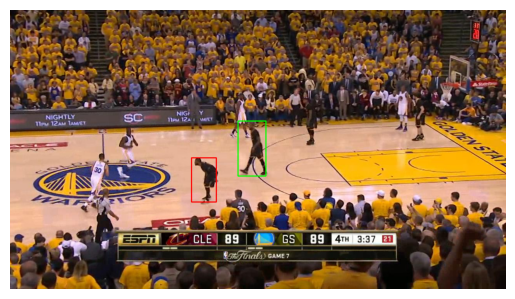

([468.0, 381.0, 64.0, 114.0], [588.0, 286.0, 72.0, 142.0])

In [28]:
img_index = 50
seq_path = f'./data/seq1/img/000000{img_index}.jpg'
vis_img = cv2.imread(seq_path)

result_box = load_boxes_data("./results/ODA/trackresults_ODA_seq1.txt")[img_index]
ground_truth_box = load_boxes_data("./data/seq1/groundtruth.txt")[img_index]
visualization(vis_img,result_box,ground_truth_box)

result_box,ground_truth_box